# Modelo de Detección de Fraude utilizando Computer Vision

Este notebook es la continuación del proyecto de generación del modelo de detección de fraude utilizando Computer Vision. Hasta este punto lo que se ha realizado es la descarga del dataset con el que se va a utilizar y la generación de los vectores característicos de las imágenes y de las etiquetas con los que se va a entrenar el modelo. A continuación se procede a implementar el entrenamiento del modelo y el ajuste de sus hiperparámetros con el fin de obtener el mejor modelo posible.

Al igual que en el notebook anterior, todas las celdas están explicadas para justificar todas las decisiones tomadas.

# Importación de Vectores Característicos

En primer lugar importamos los vectores generados en el notebook anterior. Estos vectores son los que se va a trabajar para entrenar el modelo.

In [ ]:
import os

In [ ]:
# Autenticar al usuario en Google Colab
from google.colab import auth
auth.authenticate_user()

# Obtener credenciales del entorno
from googleapiclient.discovery import build
import google.auth
creds, _ = google.auth.default()

# Crear el servicio de Google Drive
drive_service = build('drive', 'v3', credentials=creds)

# Especificar el ID de la carpeta en Google Drive
folder_id = '1SpbMa6N6PleWgHWE5Gr8bgzDfK8nAN-0'

# Lista de nombres de archivos a descargar
file_names = [
    "images_train_features.npy",
    "images_test_features.npy",
    "images_validation_features.npy",
    "np_labels_train.npy",
    "np_labels_validation.npy",
    "np_labels_test.npy"
]

# Crear el directorio de descarga
download_dir = '/content/google_drive_files'
os.makedirs(download_dir, exist_ok=True)

# Importar MediaIoBaseDownload
from googleapiclient.http import MediaIoBaseDownload
import io
import numpy as np

# Función para buscar un archivo por nombre en una carpeta específica y descargarlo
def download_file_by_name(service, folder_id, file_name, save_path):
    # Buscar el archivo en la carpeta especificada
    query = f"'{folder_id}' in parents and name='{file_name}' and trashed=false"
    results = service.files().list(q=query, spaces='drive', fields='files(id, name)').execute()
    items = results.get('files', [])

    if not items:
        print(f"No se encontró el archivo: {file_name}")
        return False

    file_id = items[0]['id']
    request = service.files().get_media(fileId=file_id)
    fh = io.FileIO(save_path, 'wb')
    downloader = MediaIoBaseDownload(fh, request)
    done = False

    while not done:
        status, done = downloader.next_chunk()
        if status:
            print(f"Descargando {file_name}: {int(status.progress() * 100)}%.")

    fh.close()
    print(f"{file_name} descargado en {save_path}.")
    return True

# Descargar y cargar cada archivo en una variable
for file_name in file_names:
    save_path = os.path.join(download_dir, file_name)
    if download_file_by_name(drive_service, folder_id, file_name, save_path):
        # Cargar el archivo en una variable de NumPy con el mismo nombre que el archivo (sin extensión)
        var_name = file_name.split('.')[0]
        globals()[var_name] = np.load(save_path)

# Verificar que los archivos se han cargado en variables
for file_name in file_names:
    var_name = file_name.split('.')[0]
    if var_name in globals():
        print(f"{var_name} cargado con éxito en una variable.")



Descargando images_train_features.npy: 84%.
Descargando images_train_features.npy: 100%.
images_train_features.npy descargado en /content/google_drive_files/images_train_features.npy.
Descargando images_test_features.npy: 100%.
images_test_features.npy descargado en /content/google_drive_files/images_test_features.npy.
Descargando images_validation_features.npy: 100%.
images_validation_features.npy descargado en /content/google_drive_files/images_validation_features.npy.
Descargando np_labels_train.npy: 100%.
np_labels_train.npy descargado en /content/google_drive_files/np_labels_train.npy.
Descargando np_labels_validation.npy: 100%.
np_labels_validation.npy descargado en /content/google_drive_files/np_labels_validation.npy.
Descargando np_labels_test.npy: 100%.
np_labels_test.npy descargado en /content/google_drive_files/np_labels_test.npy.
images_train_features cargado con éxito en una variable.
images_test_features cargado con éxito en una variable.
images_validation_features cargad

Comprobamos que todos ficheros se han descargado correctamente.

In [ ]:
print('Dimensión del vector característico de imágenes de train:',images_train_features.shape)
print('Dimensión del vector característico de imágenes de validación:',images_validation_features.shape)
print('Dimensión del vector característico de imágenes de test:',images_test_features.shape)
print('Dimensión del array de etiquetas de train:',np_labels_train.shape)
print('Dimensión del array de etiquetas de validación:',np_labels_validation.shape)
print('Dimensión del array de etiquetas de test:',np_labels_test.shape)

Dimensión del vector característico de imágenes de train: (15144, 2048)
Dimensión del vector característico de imágenes de validación: (6648, 2048)
Dimensión del vector característico de imágenes de test: (4413, 2048)
Dimensión del array de etiquetas de train: (15144, 2)
Dimensión del array de etiquetas de validación: (6648, 2)
Dimensión del array de etiquetas de test: (4413, 2)


# Generación y entrenamiento del modelo

Como se ha comentado en el notebook anterior, para crear este modelo de detección de fraudes vamos a utilizar un modelos preentrenado: el modelo ResNet50. Nos hemos decantado por utilizar este modelo por las siguientes razones:

* Eficiencia en tiempo y recursos: El modelo ResNet50 ha sido entrenado con grandes conjuntos de datos por lo que extrae facilmente características útiles de imágenes. En este caso, como se trata de extraer características de imágenes, esto nos va a permitir ahorrar tiempo y recursos en comparación a entrenar un nuevo modelo desde cero.

* Robustez: Este modelo preentrenado tiende a ser robusto y tiene la capacidad de generalizar bien debido a que ha sido entrenado con grandes volúmenes de datos. Esto puede ser interesante si posteriormente se realiza un fine-tunning ya que se estaría ajustando este modelo al problema de detección de fraudes.

* Experiencia y conocimientos: En la comunidad de visión por computadora, el modelo ResNet50 es un modelo muy probado y aceptado por la comunidad. Son muchos los expiertos que avalan el uso de este mdodelo debido a que se afirma que como base este modelo puede ser muy bueno para utilizar.

Por todo ello, vamos a utilizar el modelos ResNet50 como modelo base y le añadirimos un clasificador de tipo dense con una capa con dos neuronas (ficticia o no ficticia). Por ello, en primer lugar importamos el modelo ResNet50 pre-entrenado y comprobamos su arquitectura.

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

# Importo el modelo ResNet50 pre-entrenado
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

Llegados a este punto es importante destacar que objetivamente sería mucho mejor entrenar todo el modelo desde cero, es decir, descongelar todas las capas, añadir el clasificador y entrenarlo con los tensores directamente. El problema de ello es que el coste puede ser muy elevado y es por eso que hemos generado previamente los vectores característicos y vamos a entrenar unicamente el clasificador.

Para entrenar el clasificador, en primer lugar vamos a realizar un barrido aleatorio de posibles parámetros para tener una primera idea sobre que hiperparámetros son los mejores. Para ello utilizaramos la función hyper_opt. Luego una vez tenga una cota de posibles valores, lo iremos ajustando.

In [ ]:
from hyperopt import hp, fmin, tpe, Trials
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import sys
import time
from hyperopt import STATUS_OK

# Espacio de búsqueda de hiperparámetros
space = {
    'learning_rate': hp.choice('learning_rate', [1.0, 0.5,0.1]),
    'lr_decay': hp.choice('lr_decay', [0.005]),
    'num_epochs': hp.choice('num_epochs', [20,40,80]),
    'batch_size': hp.choice('batch_size', [32, 128, 512])
}

# Defino unos callbacks para que la red pare cuando no vea mejora
def get_callbacks(pars):
    callbacks = [EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=2, verbose=0, mode='auto')]
    return callbacks

def mi_cnn(pars):
    print('Parameters: ', pars)

    # Extraigo los parámetros del espacio de búsqueda
    learning_rate = pars['learning_rate']
    lr_decay = pars['lr_decay']
    num_epochs = pars['num_epochs']
    batch_size = pars['batch_size']

    # Implemento la red empleando Keras
    model = Sequential()
    model.add(Dense(256, input_shape=(images_train_features.shape[1],), activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(2, activation='softmax'))

    # Compilo y entreno el modelo SGD
    print("[INFO]: Entrenando red neuronal...")
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
        initial_learning_rate=learning_rate,
        decay_steps=1,
        decay_rate=lr_decay
    )
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

    # Entreno la solución
    history = model.fit(images_train_features, np_labels_train, validation_data=(images_validation_features, np_labels_validation), epochs=num_epochs, batch_size=batch_size)

    best_epoch_loss = np.argmin(history.history['val_loss'])
    best_val_loss = np.min(history.history['val_loss'])
    best_val_acc = np.max(history.history['val_accuracy'])

    print('Epoch {} - val acc: {} - val loss: {}'.format(best_epoch_loss, best_val_acc, best_val_loss))
    sys.stdout.flush()

    return {'loss': best_val_loss, 'best_epoch': best_epoch_loss, 'eval_time': time.time(), 'status': STATUS_OK, 'model': model, 'history': history}


In [ ]:
# Definir los trials para almacenar los resultados de la optimización
trials = Trials()

# Realizar la optimización utilizando Hyperopt
best = fmin(fn=mi_cnn,
            space=space,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials)

# Imprimir los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(best)

Streaming output truncated to the last 5000 lines.
474/474 [==============================] - 7s 15ms/step - loss: 0.6212 - accuracy: 0.6531 - val_loss: 0.7260 - val_accuracy: 0.5484

Epoch 9/20

474/474 [==============================] - 7s 14ms/step - loss: 0.6160 - accuracy: 0.6581 - val_loss: 0.6620 - val_accuracy: 0.6057

Epoch 10/20

474/474 [==============================] - 7s 14ms/step - loss: 0.6141 - accuracy: 0.6612 - val_loss: 0.6507 - val_accuracy: 0.6169

Epoch 11/20

474/474 [==============================] - 7s 15ms/step - loss: 0.6106 - accuracy: 0.6642 - val_loss: 0.6699 - val_accuracy: 0.6101

Epoch 12/20

474/474 [==============================] - 7s 14ms/step - loss: 0.6055 - accuracy: 0.6711 - val_loss: 0.6406 - val_accuracy: 0.6261

Epoch 13/20

474/474 [==============================] - 7s 16ms/step - loss: 0.6014 - accuracy: 0.6708 - val_loss: 0.6380 - val_accuracy: 0.6312

Epoch 14/20

474/474 [==============================] - 7s 14ms/step - loss: 0.6000 - a

Tras la ejecuón de la función hyper-opt el resultado ha sido:

Mejores hiperparámetros encontrados:
{'batch_size': 0, 'learning_rate': 2, 'lr_decay': 0, 'num_epochs': 2}

Lo que está indicando esta línea es el índice dentro de la lista he definido para cada hiperparámetro. Teniendo en cuenta que python se indexa en 0 y que el espacio definido ha sido el siguiente:


*   learning_rate = [1.0, 0.5,0.1]
*   lr_decay = [0.005]
*   num_epochs = [20,40,80]
*   batch_size = [32, 128, 512]

Los mejores hiper-parámetros encontrados son:

*   learning_rate = 0.1
*   lr_decay = 0.005
*   num_epochs = 80
*   batch_size = 32

Por lo tanto, ejecutamos de nuevo la red con los valores encontrados por la función hyper-opt para poder visualizar la gráfica de pérdidas.

In [ ]:
def clasificador_red_convolucional(learning_rate, lr_decay, batch_size, num_epochs):

  # Implementamos la red empleando Keras
  model = Sequential()
  model.add(Dense(256,input_shape=(images_train_features.shape[1],), activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(2, activation='softmax'))

  # Compilamos y entrenamos el modelo SGD
  print("[INFO]: Entrenando red neuronal...")
  lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
      initial_learning_rate=learning_rate,
      decay_steps=1,
      decay_rate=lr_decay
  )
  optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
  model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

  # Entrenando la solución
  H = model.fit(images_train_features, np_labels_train, validation_data=(images_validation_features, np_labels_validation), epochs=num_epochs, batch_size=batch_size)

  # Evaluando el modelo de predicción con las imágenes de test
  print("[INFO]: Evaluando red neuronal...")
  predictions_modelo2D = model.predict(images_test_features, batch_size=batch_size)
  print(classification_report(np_labels_test.argmax(axis=1), predictions_modelo2D.argmax(axis=1)))

  # Muestro gráfica de accuracy y losses
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, num_epochs), H.history["loss"], label="train_loss")
  plt.plot(np.arange(0, num_epochs), H.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, num_epochs), H.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, num_epochs), H.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()

[INFO]: Entrenando red neuronal...
Epoch 1/80
474/474 [==============================] - 10s 15ms/step - loss: 0.6857 - accuracy: 0.5639 - val_loss: 0.6996 - val_accuracy: 0.5310
Epoch 2/80
474/474 [==============================] - 8s 17ms/step - loss: 0.6627 - accuracy: 0.5968 - val_loss: 0.6829 - val_accuracy: 0.5727
Epoch 3/80
474/474 [==============================] - 7s 15ms/step - loss: 0.6528 - accuracy: 0.6119 - val_loss: 0.6909 - val_accuracy: 0.5725
Epoch 4/80
474/474 [==============================] - 7s 14ms/step - loss: 0.6424 - accuracy: 0.6321 - val_loss: 0.6798 - val_accuracy: 0.5952
Epoch 5/80
474/474 [==============================] - 5s 11ms/step - loss: 0.6341 - accuracy: 0.6446 - val_loss: 0.7652 - val_accuracy: 0.5338
Epoch 6/80
474/474 [==============================] - 5s 11ms/step - loss: 0.6276 - accuracy: 0.6478 - val_loss: 0.7459 - val_accuracy: 0.5520
Epoch 7/80
474/474 [==============================] - 4s 9ms/step - loss: 0.6233 - accuracy: 0.6510 - val_

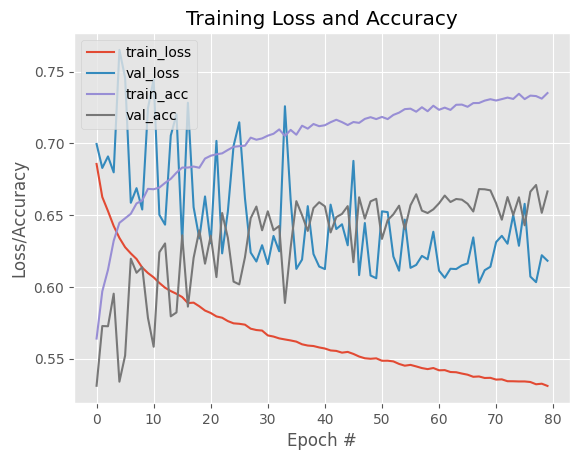

In [ ]:
learning_rate = 0.1
lr_decay = 0.005
num_epochs = 80
batch_size = 32
clasificador_red_convolucional(learning_rate, lr_decay, batch_size, num_epochs)

Las gráficas obtenidas no son nada buenas. Observando unicamente las gráficas correspondientes al conjunto de entrenamiento es posible apreciar como la gráfica de pérdidas (la roja) parece que tiene buena pinta porque comienza a percibirse el codo que indica que el modelo está aprendiendo. Esta idea también se refuerza con la gráfica de accuracy de train ya que se puede apreciar como el la gráfica asciende y parece que se va estabilizando.

Sin embargo, para el caso del conjunto de validación aunque ambas gráfica parecen que tienen una dirección y sentido que es el adecuado, se observan unas oscilaciones que parece que hacen indicar que el learning rate es elevado. Es por eso que vamos a realizar otro entrenamiento disminuyendo su tamaño para intentar obtener mejores resultados.

[INFO]: Entrenando red neuronal...
Epoch 1/80
474/474 [==============================] - 8s 13ms/step - loss: 0.6738 - accuracy: 0.5753 - val_loss: 0.7060 - val_accuracy: 0.5212
Epoch 2/80
474/474 [==============================] - 4s 7ms/step - loss: 0.6610 - accuracy: 0.6020 - val_loss: 0.6889 - val_accuracy: 0.5576
Epoch 3/80
474/474 [==============================] - 5s 10ms/step - loss: 0.6560 - accuracy: 0.6144 - val_loss: 0.6868 - val_accuracy: 0.5641
Epoch 4/80
474/474 [==============================] - 3s 7ms/step - loss: 0.6522 - accuracy: 0.6174 - val_loss: 0.6908 - val_accuracy: 0.5588
Epoch 5/80
474/474 [==============================] - 4s 7ms/step - loss: 0.6497 - accuracy: 0.6222 - val_loss: 0.6910 - val_accuracy: 0.5620
Epoch 6/80
474/474 [==============================] - 4s 9ms/step - loss: 0.6473 - accuracy: 0.6270 - val_loss: 0.6836 - val_accuracy: 0.5653
Epoch 7/80
474/474 [==============================] - 5s 11ms/step - loss: 0.6454 - accuracy: 0.6270 - val_loss

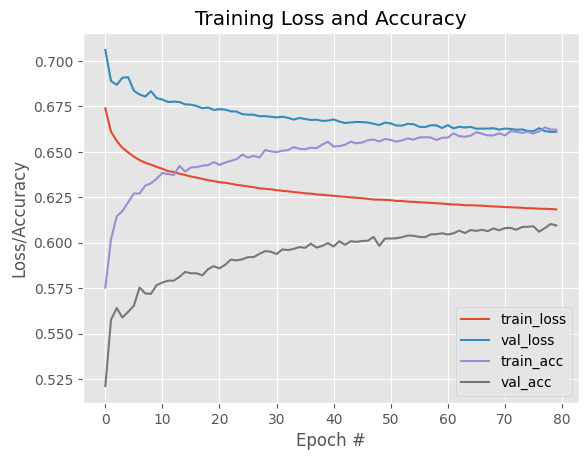

In [ ]:
learning_rate = 0.01
lr_decay = 0.005
num_epochs = 80
batch_size = 32
clasificador_red_convolucional(learning_rate, lr_decay, batch_size, num_epochs)

Tras diminuir el learning rate es posible apreciar como las oscilaciones en las curvas han disminuido. Se puede apreciar como tanto las curvas de pérdidas como de accuracy, ambas tienen buena pinta porque indican que el modelo está aprendiendo y está consiguiendo distinguir imágenes ficticias de no ficticias.

No obstante, se puede apreciar una diferencia de accuracy entre el conjunto de train y el de validación y esto hace indicar que puede ser que el modelo se este ajustando mucho a los datos de train (overfitting). Es por eso que para que el modelo generalice mejor, vamos a añadir capas de BatchNormalization.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation


def clasificador_red_convolucional(learning_rate, lr_decay, batch_size, num_epochs):

  # Implementamos la red empleando Keras
  model = Sequential()
  model.add(Dense(256, input_shape=(images_train_features.shape[1],)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  model.add(Dense(128))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  model.add(Dense(64))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  model.add(Dense(2, activation='softmax'))

   # Compilamos y entrenamos el modelo SGD
  print("[INFO]: Entrenando red neuronal...")
  lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
      initial_learning_rate=learning_rate,
      decay_steps=1,
      decay_rate=lr_decay
  )
  optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
  model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

  # Entrenando la solución
  H = model.fit(images_train_features, np_labels_train, validation_data=(images_validation_features, np_labels_validation), epochs=num_epochs, batch_size=batch_size)

  # Evaluando el modelo de predicción con las imágenes de test
  print("[INFO]: Evaluando red neuronal...")
  predictions_modelo = model.predict(images_test_features, batch_size=256)
  print(classification_report(np_labels_test.argmax(axis=1), predictions_modelo.argmax(axis=1)))

  # Muestro gráfica de accuracy y losses
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, num_epochs), H.history["loss"], label="train_loss")
  plt.plot(np.arange(0, num_epochs), H.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, num_epochs), H.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, num_epochs), H.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()

Probamos con los hiperparámetros del último entrenamiento.

[INFO]: Entrenando red neuronal...
Epoch 1/80
474/474 [==============================] - 10s 17ms/step - loss: 0.6710 - accuracy: 0.6106 - val_loss: 0.6750 - val_accuracy: 0.5967
Epoch 2/80
474/474 [==============================] - 4s 9ms/step - loss: 0.6042 - accuracy: 0.6679 - val_loss: 0.6631 - val_accuracy: 0.6188
Epoch 3/80
474/474 [==============================] - 5s 11ms/step - loss: 0.5848 - accuracy: 0.6899 - val_loss: 0.6583 - val_accuracy: 0.6224
Epoch 4/80
474/474 [==============================] - 6s 14ms/step - loss: 0.5735 - accuracy: 0.7007 - val_loss: 0.6530 - val_accuracy: 0.6244
Epoch 5/80
474/474 [==============================] - 4s 9ms/step - loss: 0.5607 - accuracy: 0.7107 - val_loss: 0.6535 - val_accuracy: 0.6291
Epoch 6/80
474/474 [==============================] - 4s 9ms/step - loss: 0.5559 - accuracy: 0.7169 - val_loss: 0.6478 - val_accuracy: 0.6322
Epoch 7/80
474/474 [==============================] - 6s 12ms/step - loss: 0.5483 - accuracy: 0.7215 - val_lo

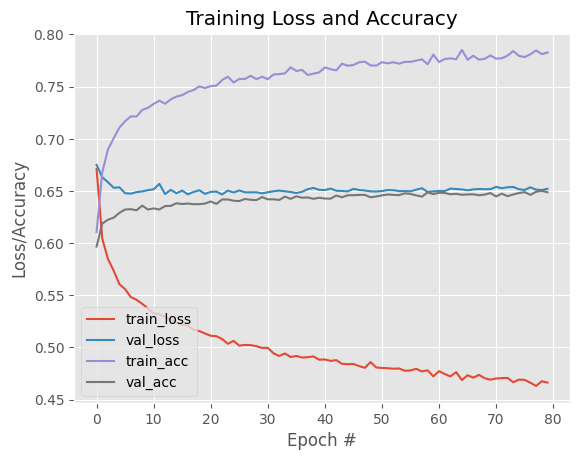

In [ ]:
learning_rate = 0.01
lr_decay = 0.005
num_epochs = 80
batch_size = 32
clasificador_red_convolucional(learning_rate, lr_decay, batch_size, num_epochs)

Añadir capas de BatchNormalization no ha mejorado significativamente los resultados. Es cierto que el modelo parece estabilizarse más rápido, pero la diferencia entre los conjuntos de entrenamiento y validación sigue siendo considerable. Esta diferencia es preocupante porque parece indicar que el modelo está sobreajustado. Se está adaptando muy bien a train pero no tanto a validación/test. Por eso, con el fin de conseguir una mejor generalización, vamos a implementar la regularización Ridge y la técnica de dropout. Nos decantamos por utilizar esta regularización debido a que no quiero que la red seleccione características, sino que queremos que genere pesos de forma más uniformemente distribuidos.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Dropout
from tensorflow.keras import regularizers
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


def clasificador_red_convolucional(learning_rate, lr_decay, batch_size, num_epochs,regularizacion,dropout_rate):

    # Implementamos la red empleando Keras
    model = Sequential()

    model.add(Dense(256, input_shape=(images_train_features.shape[1],), kernel_regularizer=regularizers.l2(regularizacion)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate))

    model.add(Dense(128, kernel_regularizer=regularizers.l2(regularizacion)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate))

    model.add(Dense(64, kernel_regularizer=regularizers.l2(regularizacion)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate))

    model.add(Dense(2, activation='softmax'))

    # Compilamos y entrenamos el modelo SGD
    print("[INFO]: Entrenando red neuronal...")
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
        initial_learning_rate=learning_rate,
        decay_steps=1,
        decay_rate=lr_decay
    )
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

    # Entrenando la solución
    H = model.fit(images_train_features, np_labels_train, validation_data=(images_validation_features, np_labels_validation), epochs=num_epochs, batch_size=batch_size)

  # Evaluando el modelo de predicción con las imágenes de test
    print("[INFO]: Evaluando red neuronal...")
    predictions_modelo2D = model.predict(images_test_features, batch_size=batch_size)
    print(classification_report(np_labels_test.argmax(axis=1), predictions_modelo2D.argmax(axis=1)))

    # Muestro gráfica de accuracy y losses
    plt.style.use("ggplot")
    fig, axs = plt.subplots(2)
    fig.suptitle('Training Metrics')

    # Gráfico para pérdida
    axs[0].plot(np.arange(0, num_epochs), H.history["loss"], label="train_loss")
    axs[0].plot(np.arange(0, num_epochs), H.history["val_loss"], label="val_loss")
    axs[0].set_title('Loss')
    axs[0].set_xlabel("Epoch #")
    axs[0].set_ylabel("Loss")
    axs[0].legend()

    # Gráfico para precisión
    axs[1].plot(np.arange(0, num_epochs), H.history["accuracy"], label="train_acc")
    axs[1].plot(np.arange(0, num_epochs), H.history["val_accuracy"], label="val_acc")
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel("Epoch #")
    axs[1].set_ylabel("Accuracy")
    axs[1].set_ylim([0, 1])
    axs[1].legend()

    plt.subplots_adjust(hspace=1)
    plt.show()

Los hiperparámetros seleccionados hasta este momento no los modificamos y de momento entrenamos la red sin dropout, solamente con regularización.

[INFO]: Entrenando red neuronal...
Epoch 1/80
474/474 [==============================] - 6s 10ms/step - loss: 7.3957 - accuracy: 0.6051 - val_loss: 7.1244 - val_accuracy: 0.5981
Epoch 2/80
474/474 [==============================] - 3s 7ms/step - loss: 6.9134 - accuracy: 0.6737 - val_loss: 6.8601 - val_accuracy: 0.6178
Epoch 3/80
474/474 [==============================] - 3s 7ms/step - loss: 6.6803 - accuracy: 0.6911 - val_loss: 6.6744 - val_accuracy: 0.6241
Epoch 4/80
474/474 [==============================] - 4s 9ms/step - loss: 6.5195 - accuracy: 0.7085 - val_loss: 6.5608 - val_accuracy: 0.6242
Epoch 5/80
474/474 [==============================] - 4s 8ms/step - loss: 6.4008 - accuracy: 0.7203 - val_loss: 6.4522 - val_accuracy: 0.6322
Epoch 6/80
474/474 [==============================] - 3s 7ms/step - loss: 6.3108 - accuracy: 0.7227 - val_loss: 6.3718 - val_accuracy: 0.6385
Epoch 7/80
474/474 [==============================] - 4s 7ms/step - loss: 6.2297 - accuracy: 0.7276 - val_loss: 

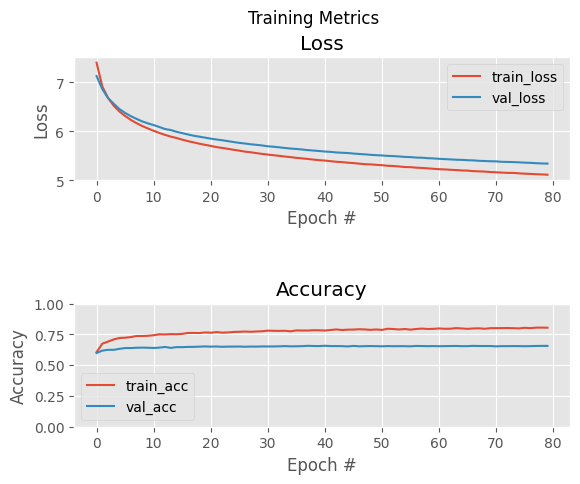

In [ ]:
learning_rate = 0.01
lr_decay = 0.005
num_epochs = 80
batch_size = 32
regularizacion = 0.01
dropout_rate = 0.0
clasificador_red_convolucional(learning_rate, lr_decay, batch_size, num_epochs,regularizacion,dropout_rate)

Como se puede observar, hemos dividido las gráficas en dos partes. Esto se debe a que las pérdidas y el accuracy estaban fuera de escala, lo que impedía visualizar correctamente las curvas de accuracy. A priori, las pérdidas y el accuracy tienen buena pinta. Es cierto que la gráfica de accuracy de validación apenas mejora pero si que se observa que tiende a estabilizarse.

Por otro lado, ahora vamos añadir dropout. Al añadirlo seguramente lo que pase es que pierda accuracy pero por contra ganaremos generalización y más robustez, lo cual creo que es más óptimo ya que el modelo tendrá mejor rendimiento en situaciones del mundo real. Aplicamos un dropout de 0.1

[INFO]: Entrenando red neuronal...
Epoch 1/80
474/474 [==============================] - 9s 10ms/step - loss: 42.1124 - accuracy: 0.5675 - val_loss: 27.6021 - val_accuracy: 0.5875
Epoch 2/80
474/474 [==============================] - 3s 7ms/step - loss: 22.2082 - accuracy: 0.6117 - val_loss: 18.2643 - val_accuracy: 0.5913
Epoch 3/80
474/474 [==============================] - 3s 7ms/step - loss: 15.9105 - accuracy: 0.6245 - val_loss: 14.0117 - val_accuracy: 0.6083
Epoch 4/80
474/474 [==============================] - 4s 9ms/step - loss: 12.6517 - accuracy: 0.6415 - val_loss: 11.5271 - val_accuracy: 0.6236
Epoch 5/80
474/474 [==============================] - 4s 8ms/step - loss: 10.6286 - accuracy: 0.6566 - val_loss: 9.8819 - val_accuracy: 0.6357
Epoch 6/80
474/474 [==============================] - 4s 8ms/step - loss: 9.2394 - accuracy: 0.6679 - val_loss: 8.7014 - val_accuracy: 0.6449
Epoch 7/80
474/474 [==============================] - 4s 7ms/step - loss: 8.2138 - accuracy: 0.6750 - v

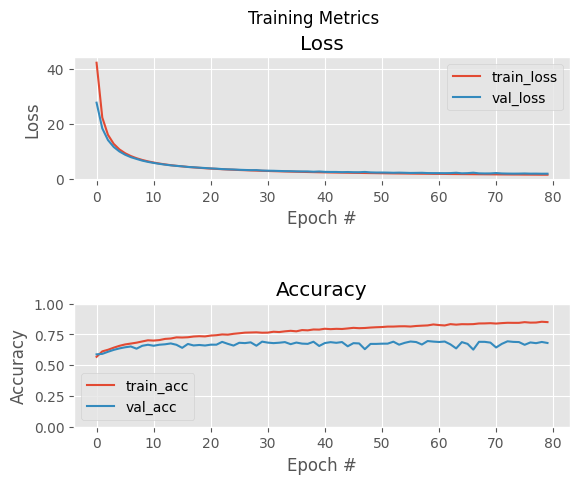

In [ ]:
learning_rate = 0.01
lr_decay = 0.005
num_epochs = 80
batch_size = 32
regularizacion = 0.1
dropout_rate = 0.2
clasificador_red_convolucional(learning_rate, lr_decay, batch_size, num_epochs,regularizacion,dropout_rate)

Seguidamente vamos a aumentar el batch size para comprobar si dando la posibilidad al modelo de ver más imágenes por cada vuelta, es capaz de generalizar o encontrar unos patrones que mejoren el rendimiento del modelo.

[INFO]: Entrenando red neuronal...
Epoch 1/80
119/119 [==============================] - 3s 11ms/step - loss: 7.8062 - accuracy: 0.5487 - val_loss: 7.5639 - val_accuracy: 0.5632
Epoch 2/80
119/119 [==============================] - 1s 8ms/step - loss: 7.5277 - accuracy: 0.5775 - val_loss: 7.3955 - val_accuracy: 0.5636
Epoch 3/80
119/119 [==============================] - 1s 8ms/step - loss: 7.3564 - accuracy: 0.5885 - val_loss: 7.2692 - val_accuracy: 0.5737
Epoch 4/80
119/119 [==============================] - 1s 8ms/step - loss: 7.2286 - accuracy: 0.5953 - val_loss: 7.1628 - val_accuracy: 0.5871
Epoch 5/80
119/119 [==============================] - 1s 8ms/step - loss: 7.1296 - accuracy: 0.6044 - val_loss: 7.0745 - val_accuracy: 0.5954
Epoch 6/80
119/119 [==============================] - 1s 10ms/step - loss: 7.0454 - accuracy: 0.6077 - val_loss: 7.0034 - val_accuracy: 0.5969
Epoch 7/80
119/119 [==============================] - 1s 12ms/step - loss: 6.9709 - accuracy: 0.6121 - val_loss

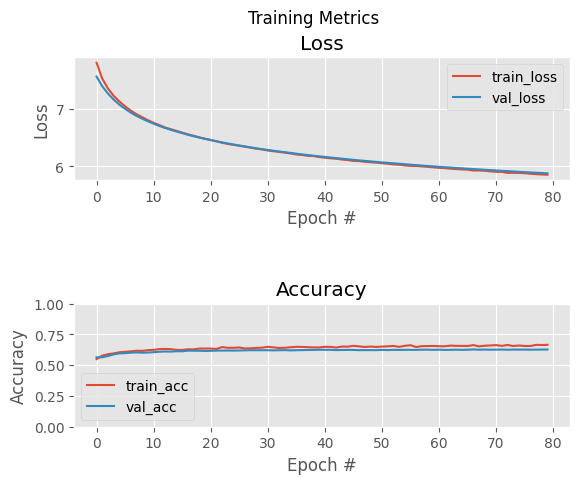

In [ ]:
learning_rate = 0.01
lr_decay = 0.005
num_epochs = 80
batch_size = 128
regularizacion = 0.01
dropout_rate = 0.2
clasificador_red_convolucional(learning_rate, lr_decay, batch_size, num_epochs,regularizacion,dropout_rate)

Aumentando el batch size es posible apreciar como el modelo ha empeorado. Por lo tanto vamos a realizar la inversa, vamos a disminuir el batch size a 16 para ver si así mejora.

[INFO]: Entrenando red neuronal...
Epoch 1/80
947/947 [==============================] - 9s 8ms/step - loss: 7.2603 - accuracy: 0.5674 - val_loss: 6.8847 - val_accuracy: 0.5808
Epoch 2/80
947/947 [==============================] - 7s 8ms/step - loss: 6.7261 - accuracy: 0.5953 - val_loss: 6.5844 - val_accuracy: 0.5964
Epoch 3/80
947/947 [==============================] - 8s 8ms/step - loss: 6.4853 - accuracy: 0.6117 - val_loss: 6.4081 - val_accuracy: 0.5987
Epoch 4/80
947/947 [==============================] - 7s 7ms/step - loss: 6.3407 - accuracy: 0.6125 - val_loss: 6.2776 - val_accuracy: 0.6045
Epoch 5/80
947/947 [==============================] - 8s 8ms/step - loss: 6.2249 - accuracy: 0.6146 - val_loss: 6.1837 - val_accuracy: 0.6069
Epoch 6/80
947/947 [==============================] - 7s 7ms/step - loss: 6.1385 - accuracy: 0.6146 - val_loss: 6.1026 - val_accuracy: 0.6100
Epoch 7/80
947/947 [==============================] - 8s 8ms/step - loss: 6.0651 - accuracy: 0.6195 - val_loss: 6

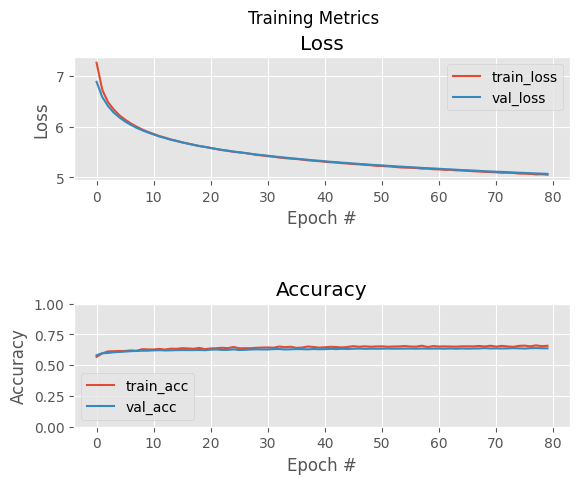

In [ ]:
learning_rate = 0.01
lr_decay = 0.005
num_epochs = 80
batch_size = 16
regularizacion = 0.01
dropout_rate = 0.2
clasificador_red_convolucional(learning_rate, lr_decay, batch_size, num_epochs,regularizacion,dropout_rate)

Con batch size de 16 es curioso obsersar como el accuracy en train y en validación no mejora pasadas las 5 épocas. Aumentamos el batch size a 64.

[INFO]: Entrenando red neuronal...
Epoch 1/80
237/237 [==============================] - 4s 9ms/step - loss: 7.6221 - accuracy: 0.5567 - val_loss: 7.3608 - val_accuracy: 0.5621
Epoch 2/80
237/237 [==============================] - 2s 8ms/step - loss: 7.2488 - accuracy: 0.5946 - val_loss: 7.1194 - val_accuracy: 0.5817
Epoch 3/80
237/237 [==============================] - 2s 8ms/step - loss: 7.0489 - accuracy: 0.6017 - val_loss: 6.9578 - val_accuracy: 0.6015
Epoch 4/80
237/237 [==============================] - 2s 8ms/step - loss: 6.9028 - accuracy: 0.6049 - val_loss: 6.8451 - val_accuracy: 0.5990
Epoch 5/80
237/237 [==============================] - 2s 8ms/step - loss: 6.7939 - accuracy: 0.6103 - val_loss: 6.7451 - val_accuracy: 0.6076
Epoch 6/80
237/237 [==============================] - 3s 11ms/step - loss: 6.7049 - accuracy: 0.6165 - val_loss: 6.6701 - val_accuracy: 0.6026
Epoch 7/80
237/237 [==============================] - 2s 8ms/step - loss: 6.6291 - accuracy: 0.6249 - val_loss: 

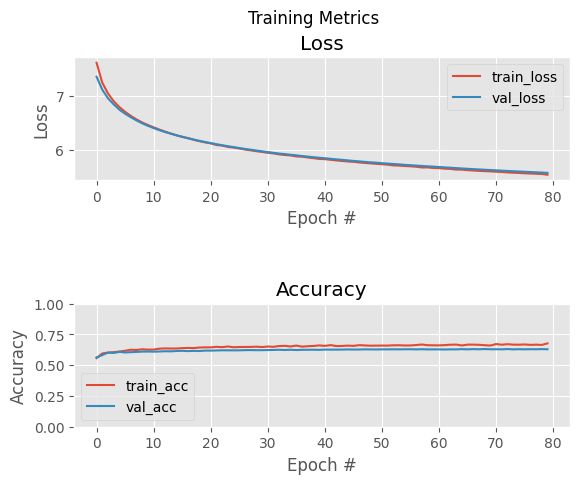

In [ ]:
learning_rate = 0.01
lr_decay = 0.005
num_epochs = 80
batch_size = 64
regularizacion = 0.01
dropout_rate = 0.2
clasificador_red_convolucional(learning_rate, lr_decay, batch_size, num_epochs,regularizacion,dropout_rate)

Como es posible apreciar, más o menos estamos obteniendo resultados parecidos. Es cierto que en función del batch hay alguna pequeña diferencia pero en general el accuracy oscila entorno a 0.65 más o menos.

Asimismo, vamos a comprobar como afecta la regularización al modelo. Para ello, vamos a aumentar su valor a 0.1 para comprobar si con ello mejoraría el modelo.

Epoch 1/80
237/237 [==============================] - 9s 27ms/step - loss: 4.5074 - accuracy: 0.5519 - val_loss: 1.6637 - val_accuracy: 0.5068 - lr: 0.0100
Epoch 2/80
237/237 [==============================] - 7s 30ms/step - loss: 1.5443 - accuracy: 0.5482 - val_loss: 1.5681 - val_accuracy: 0.4952 - lr: 0.0100
Epoch 3/80
237/237 [==============================] - 6s 25ms/step - loss: 1.3519 - accuracy: 0.5496 - val_loss: 4.6173 - val_accuracy: 0.4964 - lr: 0.0100
Epoch 4/80
237/237 [==============================] - 8s 32ms/step - loss: 1.3076 - accuracy: 0.5485 - val_loss: 1.5348 - val_accuracy: 0.4962 - lr: 0.0100
Epoch 5/80
237/237 [==============================] - 6s 25ms/step - loss: 1.3085 - accuracy: 0.5459 - val_loss: 1.3477 - val_accuracy: 0.5036 - lr: 0.0100
Epoch 6/80
237/237 [==============================] - 7s 31ms/step - loss: 1.2391 - accuracy: 0.5479 - val_loss: 1.7819 - val_accuracy: 0.4964 - lr: 0.0100
Epoch 7/80
237/237 [==============================] - 7s 28ms/st

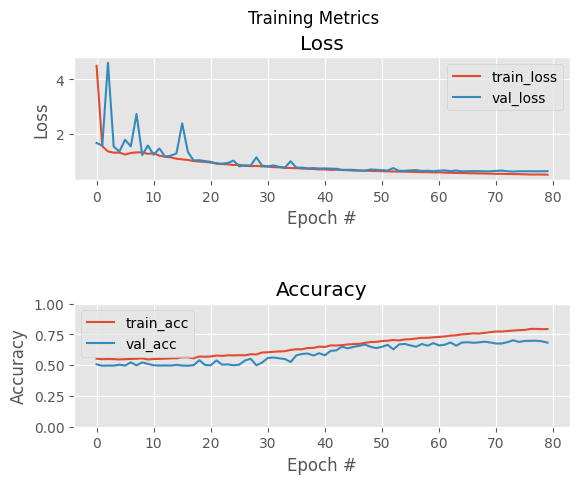

In [ ]:
learning_rate = 0.01
lr_decay = 0.005
num_epochs = 80
batch_size = 64
regularizacion = 0.1
dropout_rate = 0.2
clasificador_red_convolucional(learning_rate, lr_decay, batch_size, num_epochs,regularizacion,dropout_rate)

Aumentando la regularización, es cierto que se obtiene un mejor rendimiento pero las gráficas de pérdidas para train y validación no son suaves, sino que tiene una caida abrupta y unos picos que indican que el modelo es menos estable. Por ello, vamos a utilizar el modelo con regularización 0.01.

# Primera idea de modelo final: SDG

Una vez que realizamos distintas pruebas de entrenamiento, el modelo que obtuvimos como final era el siguiente con la siguiente combinación de hiperparámetros.

[INFO]: Entrenando red neuronal...
Epoch 1/80
474/474 [==============================] - 8s 9ms/step - loss: 41.9763 - accuracy: 0.5683 - val_loss: 27.5102 - val_accuracy: 0.5839
Epoch 2/80
474/474 [==============================] - 3s 7ms/step - loss: 22.1289 - accuracy: 0.6152 - val_loss: 18.1836 - val_accuracy: 0.6086
Epoch 3/80
474/474 [==============================] - 3s 7ms/step - loss: 15.8520 - accuracy: 0.6320 - val_loss: 13.9562 - val_accuracy: 0.6110
Epoch 4/80
474/474 [==============================] - 5s 10ms/step - loss: 12.6056 - accuracy: 0.6545 - val_loss: 11.4874 - val_accuracy: 0.6217
Epoch 5/80
474/474 [==============================] - 3s 7ms/step - loss: 10.5930 - accuracy: 0.6603 - val_loss: 9.8330 - val_accuracy: 0.6456
Epoch 6/80
474/474 [==============================] - 5s 11ms/step - loss: 9.2027 - accuracy: 0.6690 - val_loss: 8.6770 - val_accuracy: 0.6375
Epoch 7/80
474/474 [==============================] - 5s 11ms/step - loss: 8.1892 - accuracy: 0.6763 -

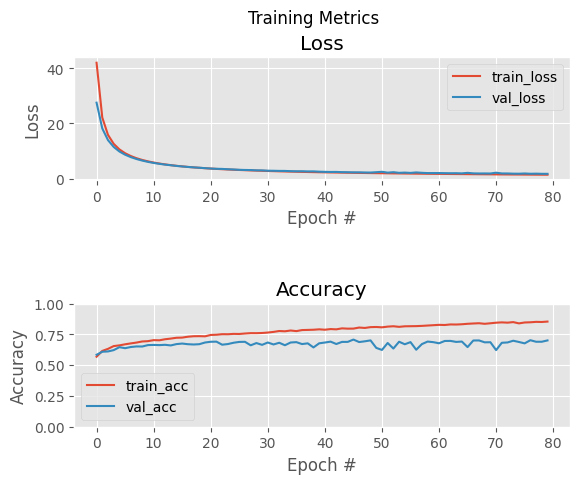

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Dropout
from tensorflow.keras import regularizers
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Implementamos la red empleando Keras
model = Sequential()

model.add(Dense(256, input_shape=(images_train_features.shape[1],), kernel_regularizer=regularizers.l2(0.1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(128, kernel_regularizer=regularizers.l2(0.1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(64, kernel_regularizer=regularizers.l2(0.1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))

# Compilamos y entrenamos el modelo SGD
print("[INFO]: Entrenando red neuronal...")
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.01,
    decay_steps=1,
    decay_rate=0.005
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Entrenando la solución
H = model.fit(images_train_features, np_labels_train, validation_data=(images_validation_features, np_labels_validation), epochs=80, batch_size=32)

# Evaluando el modelo de predicción con las imágenes de test
print("[INFO]: Evaluando red neuronal...")
predictions_modelo2D = model.predict(images_test_features, batch_size=32)
print(classification_report(np_labels_test.argmax(axis=1), predictions_modelo2D.argmax(axis=1)))

# Muestro gráfica de accuracy y losses
plt.style.use("ggplot")
fig, axs = plt.subplots(2)
fig.suptitle('Training Metrics')

# Gráfico para pérdida
axs[0].plot(np.arange(0, 80), H.history["loss"], label="train_loss")
axs[0].plot(np.arange(0, 80), H.history["val_loss"], label="val_loss")
axs[0].set_title('Loss')
axs[0].set_xlabel("Epoch #")
axs[0].set_ylabel("Loss")
axs[0].legend()

# Gráfico para precisión
axs[1].plot(np.arange(0, 80), H.history["accuracy"], label="train_acc")
axs[1].plot(np.arange(0, 80), H.history["val_accuracy"], label="val_acc")
axs[1].set_title('Accuracy')
axs[1].set_xlabel("Epoch #")
axs[1].set_ylabel("Accuracy")
axs[1].set_ylim([0, 1])
axs[1].legend()

plt.subplots_adjust(hspace=1)
plt.show()


Las gráficas obtenidas son buenas en cuanto a la forma de las mismas ya que s se puede apreciar el codo típico en la curva de pérdidas y en rendimiento, más o menos se observa como el modelo aprende y luego se estabiliza. Sin embargo, para conocer realmente el rendimiento de este modelo, generamos las métricas típicas de clasificación, su matriz de confusión y creamos un gráfico de barras para observar la diferencia entre las etiquetas reales y las predicciones.

[INFO]: Evaluando red neuronal...
35/35 [==============================] - 0s 3ms/step
[INFO]: Métricas del modelo:
Accuracy: 0.6721
Recall: 0.6531
F1 Score: 0.6659
Specificity: 0.6912
[INFO]: Matriz de confusión:
[[1524  681]
 [ 766 1442]]


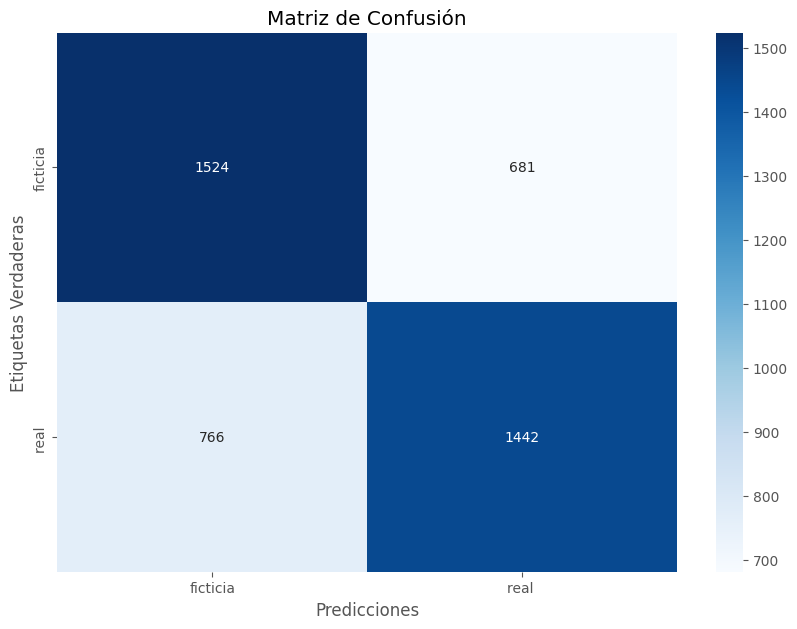

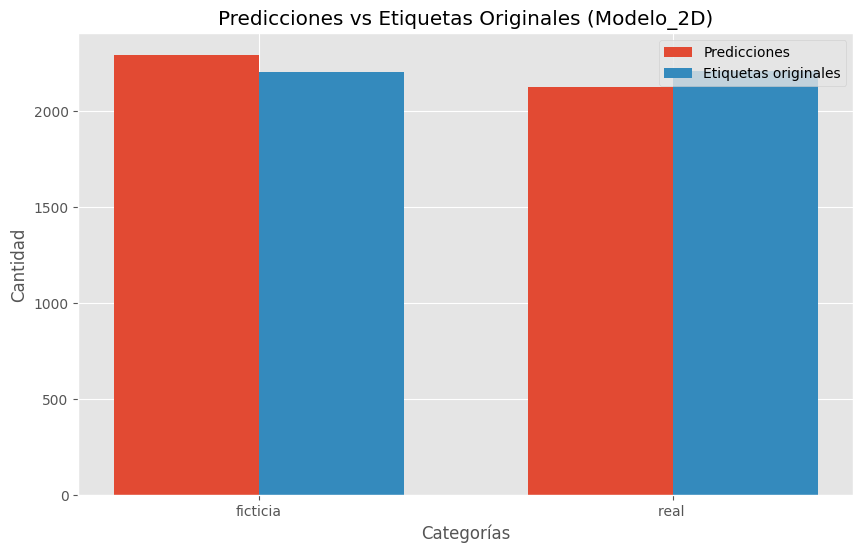

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Definir las categorías antes de usarlas
categorias = ['ficticia', 'real ']

# Definir una función para calcular la especificidad
def specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    return tn / (tn + fp)

# Evaluar el modelo
print("[INFO]: Evaluando red neuronal...")
predictions_modelo2D = model.predict(images_test_features, batch_size=128)
predicciones_clase = np.argmax(predictions_modelo2D, axis=1)
etiquetas_clase = np.argmax(np_labels_test, axis=1)

# Calcular las métricas
accuracy = accuracy_score(etiquetas_clase, predicciones_clase)
recall = recall_score(etiquetas_clase, predicciones_clase)
f1 = f1_score(etiquetas_clase, predicciones_clase)
specificity = specificity_score(etiquetas_clase, predicciones_clase)

print("[INFO]: Métricas del modelo:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Specificity: {specificity:.4f}")

# Generar la matriz de confusión
conf_matrix = confusion_matrix(etiquetas_clase, predicciones_clase)
print("[INFO]: Matriz de confusión:")
print(conf_matrix)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categorias, yticklabels=categorias)
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Verdaderas')
plt.title('Matriz de Confusión')
plt.show()

# Contar la cantidad de predicciones para cada clase
predicciones_count = [np.sum(predicciones_clase == i) for i in range(len(categorias))]
etiquetas_count = [np.sum(etiquetas_clase == i) for i in range(len(categorias))]

# Crear la gráfica de barras
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
index = np.arange(len(categorias))

# Predicciones
bar1 = ax.bar(index, predicciones_count, bar_width, label='Predicciones')

# Etiquetas originales
bar2 = ax.bar(index + bar_width, etiquetas_count, bar_width, label='Etiquetas originales')

ax.set_xlabel('Categorías')
ax.set_ylabel('Cantidad')
ax.set_title('Predicciones vs Etiquetas Originales (Modelo_2D)')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(categorias)
ax.legend()

plt.show()



Los resultados obtenidos son buenos ya que como es posible apreciar la cantidad de falsos negativos y falsos positivos es mucho menor que la cantidad de verdaderos positivos y verdaderos negativos. A priori la matriz de confusión lo que refleja es que el modelo es mucho mejor para predecir imágenes ficticias que las reales, es decir, detecta mejor cuando una imagen es ficticia que real. Tampoco es que sea una diferencia muy abrupta pero es bueno tener en cuenta esta idea a la hora de hablar del rendimiento del modelo.

Por otro lado, con el gráfico de barras se observa como prácticamente el modelo acierta la totalidad de imágenes ficticias y reales. La diferencia está en que el modelo categoriza ciertas imágenes como reales cuando en realidad son ficticias (681 de 2205, un 30% de las imágenes). Es cierto que puede parecer que el modelo en si es malo ya que de cada 10 solamente está acertando siete, sin embargo, según un estudio realizado por la Universidad de Warwick el ser humano unicamente es capaz de distinguir imágenes reales de ficticas con una precisión de un 52% y según el MIT, la tasa de acierto de los seres humanos es del 54%. Es decir, según estos dos estudios el ser humano apenas mejora el azar a la hora de detectar imágenes reales de ficticias. Dado este contexto es posible apreciar como nuestro modelo tiene mejor prestaciones que el ser humano, y aunque es cierto que su rendimiento no estan elevado como se querría, por lo menos el modelo tiende a acertar la mayoría de los casos. Es por eso por lo que consideramos que esta solución es buena.

# Modelo Final Mejorado: Adam


Si bien es cierto que el modelo anterior se puede considerar como bueno, tras analizarlo internamente en grupo, decidimos realizar unos cambios en el modelo para intentar encontrar un modelo que tuviera mejores prestaciones. A continuación presentamos los cambios más importantes introducidos.

**1. Aumento del Tamaño de las Capas**

En la primera capa densa, aumentamo el número de neuronas de 256 a 512. Esto permite que el modelo aprenda representaciones más complejas de los datos.
También añadímos una nueva capa con 256 neuronas, lo que incrementa la capacidad del modelo para capturar características más detalladas.


**2. Cambio del Optimizador y Estrategia de Tasa de Aprendizaje**

Optimizador: Cambiamos el optimizador de SGD (Stochastic Gradient Descent) a Adam. Adam es conocido por converger más rápido y ser más eficiente en muchos problemas.

Estrategia de Tasa de Aprendizaje: Anteriormente, usabamos InverseTimeDecay para disminuir la tasa de aprendizaje de manera gradual.
Ahora, implementamos un LearningRateScheduler personalizado que mantiene una tasa de aprendizaje constante durante las primeras 10 épocas y luego la disminuye exponencialmente. Esta estrategia ayuda a que el modelo aprenda rápidamente al principio y refine su aprendizaje en etapas posteriores.

**3. Regularización y Dropout**

Dropout: Mantuvimos la misma tasa de dropout para prevenir el sobreajuste, asegurando que el modelo no dependa demasiado de ninguna neurona en particular.
Regularización L2: Continuamos usando la regularización L2 en las capas densas. Esto ayuda a evitar el sobreajuste, penalizando los pesos grandes y forzando al modelo a aprender patrones más generales.

**4. Entrenamiento y Callbacks**

En el código original, usabamos SGD con un programador de tasa de aprendizaje (InverseTimeDecay).
En el nuevo código, utilizamos Adam junto con un LearningRateScheduler para ajustar dinámicamente la tasa de aprendizaje durante el entrenamiento. Esto permite un control más fino del proceso de aprendizaje, mejorando la convergencia y el rendimiento final del modelo.

El objetivo de introducir todos estos cambios es el de mejorar la capacidad del modelo para aprender de los datos generalizar mejor a datos no vistos. Por lo tanto, aplicamos los cambios y entrenamos el modelo.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Dropout
from tensorflow.keras import regularizers
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

def clasificador_red_convolucional(learning_rate, lr_decay, batch_size, num_epochs, regularizacion, dropout_rate):
    # Implementamos la red empleando Keras
    model = Sequential()

    model.add(Dense(512, input_shape=(images_train_features.shape[1],), kernel_regularizer=regularizers.l2(regularizacion)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate))

    model.add(Dense(256, kernel_regularizer=regularizers.l2(regularizacion)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate))

    model.add(Dense(128, kernel_regularizer=regularizers.l2(regularizacion)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate))

    model.add(Dense(64, kernel_regularizer=regularizers.l2(regularizacion)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate))

    model.add(Dense(2, activation='softmax'))

    # Utilizar un programador de tasa de aprendizaje
    def scheduler(epoch, lr):
        if epoch < 10:
            return lr
        else:
            return lr * tf.math.exp(-0.1)

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)

    # Compilamos y entrenamos el modelo con Adam
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

    # Entrenando la solución
    H = model.fit(images_train_features, np_labels_train, validation_data=(images_validation_features, np_labels_validation),
                  epochs=num_epochs, batch_size=batch_size, callbacks=[lr_schedule])

    # Evaluando el modelo de predicción con las imágenes de test
    print("[INFO]: Evaluando red neuronal...")
    predictions_modelo2D = model.predict(images_test_features, batch_size=batch_size)
    print(classification_report(np_labels_test.argmax(axis=1), predictions_modelo2D.argmax(axis=1)))

    # Muestro gráfica de accuracy y losses
    plt.style.use("ggplot")
    fig, axs = plt.subplots(2)
    fig.suptitle('Training Metrics')

    # Gráfico para pérdida
    axs[0].plot(np.arange(0, num_epochs), H.history["loss"], label="train_loss")
    axs[0].plot(np.arange(0, num_epochs), H.history["val_loss"], label="val_loss")
    axs[0].set_title('Loss')
    axs[0].set_xlabel("Epoch #")
    axs[0].set_ylabel("Loss")
    axs[0].legend()

    # Gráfico para precisión
    axs[1].plot(np.arange(0, num_epochs), H.history["accuracy"], label="train_acc")
    axs[1].plot(np.arange(0, num_epochs), H.history["val_accuracy"], label="val_acc")
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel("Epoch #")
    axs[1].set_ylabel("Accuracy")
    axs[1].set_ylim([0, 1])
    axs[1].legend()

    plt.subplots_adjust(hspace=1)
    plt.show()

Partiendo de los valores incluidos en las versiones anteriores de los modelos, logramos una ligera mejora mediante pequeños ajustes.

Epoch 1/50
237/237 [==============================] - 10s 28ms/step - loss: 1.8183 - accuracy: 0.5330 - val_loss: 1.5081 - val_accuracy: 0.5632 - lr: 0.0010
Epoch 2/50
237/237 [==============================] - 7s 31ms/step - loss: 1.3468 - accuracy: 0.5983 - val_loss: 1.2390 - val_accuracy: 0.5705 - lr: 0.0010
Epoch 3/50
237/237 [==============================] - 6s 25ms/step - loss: 1.1191 - accuracy: 0.6420 - val_loss: 1.0573 - val_accuracy: 0.6256 - lr: 0.0010
Epoch 4/50
237/237 [==============================] - 7s 31ms/step - loss: 0.9745 - accuracy: 0.6737 - val_loss: 0.9982 - val_accuracy: 0.6215 - lr: 0.0010
Epoch 5/50
237/237 [==============================] - 6s 25ms/step - loss: 0.8811 - accuracy: 0.6832 - val_loss: 0.9081 - val_accuracy: 0.6467 - lr: 0.0010
Epoch 6/50
237/237 [==============================] - 7s 31ms/step - loss: 0.8171 - accuracy: 0.6892 - val_loss: 0.8456 - val_accuracy: 0.6352 - lr: 0.0010
Epoch 7/50
237/237 [==============================] - 7s 28ms/s

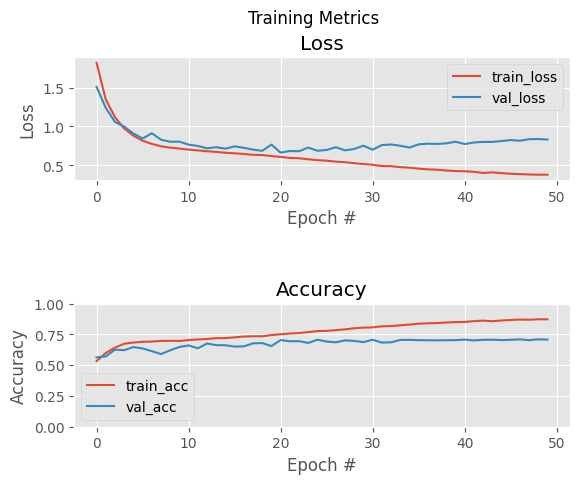

In [ ]:
# Parámetros de entrada del modelo
learning_rate = 0.001
lr_decay = 0.005
batch_size = 64
num_epochs = 50
regularizacion = 0.001
dropout_rate = 0.5

# Llamada a la función
clasificador_red_convolucional(learning_rate, lr_decay, batch_size, num_epochs, regularizacion, dropout_rate)

Aumentamos el número de épocas y obtuvimos un resultado similar. Pero nos quedamos con los anteriores valores ya que la pérdida es ligeramente más menor en el conjunto de validación.

Epoch 1/80
237/237 [==============================] - 9s 27ms/step - loss: 1.8955 - accuracy: 0.5450 - val_loss: 1.5939 - val_accuracy: 0.5570 - lr: 0.0010
Epoch 2/80
237/237 [==============================] - 7s 30ms/step - loss: 1.4442 - accuracy: 0.5784 - val_loss: 1.3134 - val_accuracy: 0.5701 - lr: 0.0010
Epoch 3/80
237/237 [==============================] - 6s 25ms/step - loss: 1.1891 - accuracy: 0.6355 - val_loss: 1.1263 - val_accuracy: 0.6276 - lr: 0.0010
Epoch 4/80
237/237 [==============================] - 7s 30ms/step - loss: 1.0359 - accuracy: 0.6615 - val_loss: 0.9959 - val_accuracy: 0.6360 - lr: 0.0010
Epoch 5/80
237/237 [==============================] - 6s 25ms/step - loss: 0.9253 - accuracy: 0.6836 - val_loss: 1.0159 - val_accuracy: 0.5540 - lr: 0.0010
Epoch 6/80
237/237 [==============================] - 8s 34ms/step - loss: 0.8587 - accuracy: 0.6873 - val_loss: 0.8629 - val_accuracy: 0.6403 - lr: 0.0010
Epoch 7/80
237/237 [==============================] - 6s 25ms/st

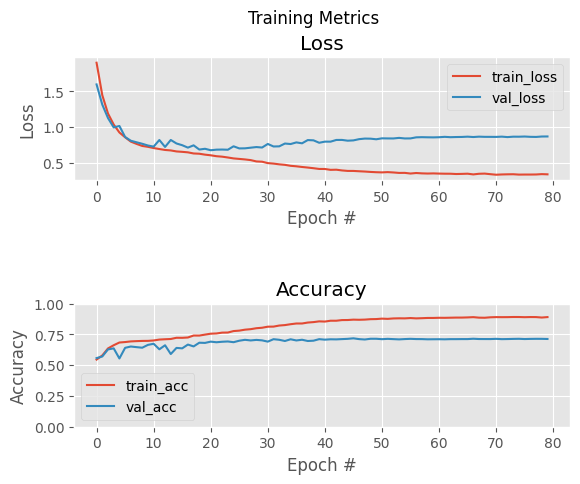

In [ ]:
# Parámetros de entrada del modelo
learning_rate = 0.001
lr_decay = 0.005
batch_size = 64
num_epochs = 80
regularizacion = 0.001
dropout_rate = 0.5

# Llamada a la función
clasificador_red_convolucional(learning_rate, lr_decay, batch_size, num_epochs, regularizacion, dropout_rate)

Podemos observar como con los cambios introducidos en el modelo, el rendimiento del modelo aumenta significativamente y además para las funciones de perdidas se aprecian el codo característico. Por ello, de igual modo que hemos hecho antes, procedemos a realizar el entrenamiento final y dibujamos la matriz de confusión y la gráfica de clasificación.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Dropout
from tensorflow.keras import regularizers
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

Epoch 1/80
237/237 [==============================] - 8s 9ms/step - loss: 1.9009 - accuracy: 0.5312 - val_loss: 1.5726 - val_accuracy: 0.5641 - lr: 0.0010
Epoch 2/80
237/237 [==============================] - 2s 8ms/step - loss: 1.4210 - accuracy: 0.5864 - val_loss: 1.2794 - val_accuracy: 0.6149 - lr: 0.0010
Epoch 3/80
237/237 [==============================] - 2s 10ms/step - loss: 1.1761 - accuracy: 0.6433 - val_loss: 1.1160 - val_accuracy: 0.6151 - lr: 0.0010
Epoch 4/80
237/237 [==============================] - 2s 10ms/step - loss: 1.0261 - accuracy: 0.6663 - val_loss: 1.1378 - val_accuracy: 0.5818 - lr: 0.0010
Epoch 5/80
237/237 [==============================] - 2s 8ms/step - loss: 0.9241 - accuracy: 0.6797 - val_loss: 0.8995 - val_accuracy: 0.6507 - lr: 0.0010
Epoch 6/80
237/237 [==============================] - 2s 8ms/step - loss: 0.8478 - accuracy: 0.6893 - val_loss: 0.8759 - val_accuracy: 0.6294 - lr: 0.0010
Epoch 7/80
237/237 [==============================] - 2s 8ms/step - 

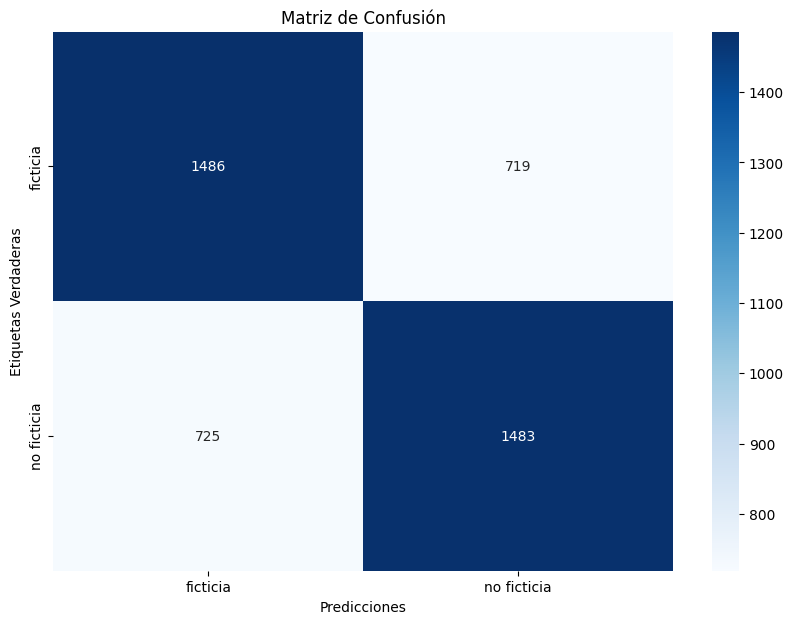

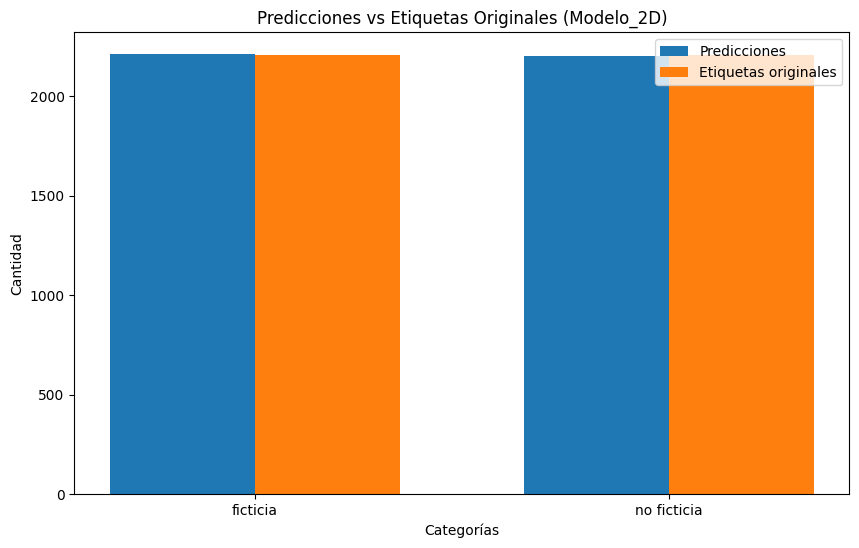

In [ ]:
# Definir una función para calcular la especificidad
def specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    return tn / (tn + fp)

# Parámetros de entrada del modelo
learning_rate = 0.001
lr_decay = 0.005
batch_size = 64
num_epochs = 80
regularizacion = 0.001
dropout_rate = 0.5

# Definir y compilar el modelo
model = Sequential()

model.add(Dense(512, input_shape=(images_train_features.shape[1],), kernel_regularizer=regularizers.l2(regularizacion)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_rate))

model.add(Dense(256, kernel_regularizer=regularizers.l2(regularizacion)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_rate))

model.add(Dense(128, kernel_regularizer=regularizers.l2(regularizacion)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_rate))

model.add(Dense(64, kernel_regularizer=regularizers.l2(regularizacion)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_rate))

model.add(Dense(2, activation='softmax'))

# Utilizar un programador de tasa de aprendizaje
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Compilamos y entrenamos el modelo con Adam
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Entrenando la solución
H = model.fit(images_train_features, np_labels_train, validation_data=(images_validation_features, np_labels_validation),
              epochs=num_epochs, batch_size=batch_size, callbacks=[lr_schedule])

# Evaluando el modelo de predicción con las imágenes de test
print("[INFO]: Evaluando red neuronal...")
predictions_modelo2D = model.predict(images_test_features, batch_size=batch_size)
predicciones_clase = np.argmax(predictions_modelo2D, axis=1)
etiquetas_clase = np.argmax(np_labels_test, axis=1)

# Calcular las métricas
accuracy = accuracy_score(etiquetas_clase, predicciones_clase)
recall = recall_score(etiquetas_clase, predicciones_clase, average='macro')
f1 = f1_score(etiquetas_clase, predicciones_clase, average='macro')
specificity = specificity_score(etiquetas_clase, predicciones_clase)

print("[INFO]: Métricas del modelo:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Specificity: {specificity:.4f}")

# Generar la matriz de confusión
conf_matrix = confusion_matrix(etiquetas_clase, predicciones_clase)
print("[INFO]: Matriz de confusión:")
print(conf_matrix)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['ficticia', 'no ficticia'], yticklabels=['ficticia', 'no ficticia'])
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Verdaderas')
plt.title('Matriz de Confusión')
plt.show()

# Contar la cantidad de predicciones para cada clase
categorias = ['ficticia', 'no ficticia']
predicciones_count = [np.sum(predicciones_clase == i) for i in range(len(categorias))]
etiquetas_count = [np.sum(etiquetas_clase == i) for i in range(len(categorias))]

# Crear la gráfica de barras
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
index = np.arange(len(categorias))

# Predicciones
bar1 = ax.bar(index, predicciones_count, bar_width, label='Predicciones')

# Etiquetas originales
bar2 = ax.bar(index + bar_width, etiquetas_count, bar_width, label='Etiquetas originales')

ax.set_xlabel('Categorías')
ax.set_ylabel('Cantidad')
ax.set_title('Predicciones vs Etiquetas Originales (Modelo_2D)')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(categorias)
ax.legend()

plt.show()

Los resultados obtenidos para este segundo modelo también son muy buenos teniendo en cuenta el contexto con el que se está trabajando. En la siguiente tabla se ofrece una comparación entre ambos modelos para que se pueda observar como el segundo modelo es mejor que el primero.

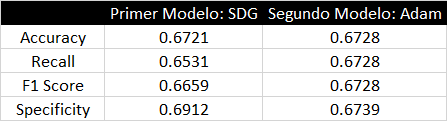

Esto lo que hace indicar es que el número de falsos negativos y positivos en este segundo modelo es menor que en el primero. Como consecuencia, el modelo categoriza más correctamente las imágenes que son reales y ficticias.

Sin embargo, es importante tener en cuenta que en este segundo modelo sigue ocurriendo lo mismo que ocurría antes y es que el modelo tiende a categorizar como ficticia más fotos que las que en realidad son. Esta idea es importante tenerla en cuenta a la hora de presentar o utilizar el modelo ya que, por ejemplo, para el caso de fraude bancario , este modelo presenta un problema menor en comparación con el escenario opuesto. El mayor inconveniente sería categorizar a una persona real como ficticia, lo cual es desfavorable para el cliente. Sin embargo, para el banco, este modelo es beneficioso ya que garantiza al 100% que ninguna transacción se realizará con una identidad ficticia. Si fuera el caso contrario sería peor ya que no se estarían detectando todas las imágenes ficticias pero en este caso, no es así y por lo tanto creemos que este modelo es bueno para el propósito que se ha creado.

Por último, a la hora de evaluar el modelo es importante tener en cuenta los estudios realizados por las universidades anteriormente mencionadas, donde se indica que el accuracy de los seres humanos para distinguir imágenes reales de ficticias es de 0,54 en el mejor de los casos. Este dato sirve para poner de relieve los resultados obtenidos.

# MLFlow

Para concluir con este proyecto, procedemos a guardar los resultados obtenidos y el modelo generado en Google Drive para que poder mostrar los resultados en MLFlow y para que el modelo pueda ser utilizado fuera de este notebook. En primer lugar guardamos el modelo en Google Drive.

In [ ]:
import os
import google.auth
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload
import joblib
import pickle

In [ ]:
# Obtener credenciales del entorno
creds, _ = google.auth.default()

# Crear el servicio de Google Drive
drive_service = build('drive', 'v3', credentials=creds)

# Guardar el modelo localmente primero
model_filename = 'modelo_entrenado.pkl'
joblib.dump(model, model_filename)

# Especificar el ID de la carpeta
folder_id = '1SpbMa6N6PleWgHWE5Gr8bgzDfK8nAN-0'

# Especificar la ruta del archivo local
file_path = model_filename

# Crear un objeto de MediaFileUpload
media = MediaFileUpload(file_path, resumable=True)

# Crear un archivo en Google Drive
file_metadata = {
    'name': os.path.basename(file_path),  # Nombre del archivo en Google Drive
    'parents': [folder_id]  # ID de la carpeta donde se guardará el archivo
}

# Subir el archivo
uploaded_file = drive_service.files().create(
    body=file_metadata,
    media_body=media,
    fields='id'
).execute()

print(f"File ID: {uploaded_file.get('id')}")
print(f"Model saved to shared Google Drive folder: https://drive.google.com/drive/folders/{folder_id}")

File ID: 1vWoKqekn0GsxAfe3FAb0i47-G0mTCIHA
Model saved to shared Google Drive folder: https://drive.google.com/drive/folders/1SpbMa6N6PleWgHWE5Gr8bgzDfK8nAN-0


In [ ]:
# Guardar el diccionario localmente primero
dict_filename = 'resultados_modelo.pkl'
with open(dict_filename, 'wb') as file:
    pickle.dump(resultados, file)

# Especificar la ruta del archivo local
file_path = dict_filename

# Crear un objeto de MediaFileUpload
media = MediaFileUpload(file_path, resumable=True)

# Crear un archivo en Google Drive
file_metadata = {
    'name': os.path.basename(file_path),  # Nombre del archivo en Google Drive
    'parents': [folder_id]  # ID de la carpeta donde se guardará el archivo
}

# Subir el archivo
uploaded_file = drive_service.files().create(
    body=file_metadata,
    media_body=media,
    fields='id'
).execute()

print(f"File ID: {uploaded_file.get('id')}")
print(f"Dictionary saved to shared Google Drive folder: https://drive.google.com/drive/folders/{folder_id}")


File ID: 1-7ZnGWIxwwoPnjVPQctFIz7QEjUQfDgP
Dictionary saved to shared Google Drive folder: https://drive.google.com/drive/folders/1SpbMa6N6PleWgHWE5Gr8bgzDfK8nAN-0


Seguidamente, almacenamos los resultados en MLFlow para que los resultados están accesibles fuera del notebook.

In [ ]:
pip install mlflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [ ]:
import mlflow
import mlflow.pyfunc
import os
import numpy as np

# URL del servidor de MLflow
mlflow.set_tracking_uri("http://52.70.78.62:5000/")

# Nombre del experimento (puedes cambiarlo según tu preferencia)
experiment_name = "Resultados de Computer Vision"
mlflow.set_experiment(experiment_name)

# Los resultados obtenidos de tu modelo
resultados = {
        'accuracy': accuracy,
        'recall': recall,
        'f1_score': f1,
        'specificity': specificity,}

with mlflow.start_run():
    # Registrar las métricas
    mlflow.log_metric("accuracy", resultados['accuracy'])
    mlflow.log_metric("recall", resultados['recall'])
    mlflow.log_metric("f1_score", resultados['f1_score'])
    mlflow.log_metric("specificity", resultados['specificity'])
